# Info

In this notebook, you'll find code for inferring the demographic histories of P. p. leucocephalus (beach) and P. p. subgriseus (mainland) with the high quality WGS data we have, as well as the divergence time. The inferred divergennce time is later used as a crown divergence consteraint in the SNAPP estimation of the population tree.

# Setup

In [3]:
import sys,os,re,glob,shutil,pickle,subprocess,math
import pandas as pd
import numpy as np
import time
import itertools
import random
%run '~/jupyter/py3_functions.py'

workdir = '/n/hoekstra_lab_tier1/Users/brock/polionotus/SMC'
!mkdir -p $workdir
os.chdir(workdir)
!mkdir -p cmds logs

infile="/n/hoekstra_lab_tier1/Users/brock/polionotus/Ppol_sizes.txt"
with open(infile, 'r') as data:          
    Ppol_sizes={}
    for line in data:
        line = line.strip("\n")
        line = line.split("\t")
        Ppol_sizes[line[0]] = int(line[1])
data.close()

from collections import defaultdict
pop_sample_map = defaultdict(list)
with open('/n/hoekstra_lab_tier1/Users/brock/polionotus/sample_map.txt','r') as data:
    for line in data:
        line = line.strip('\n')
        sample,pop = line.split('\t')
        pop_sample_map[pop].append(sample)
data.close()

coverage = '/n/hoekstra_lab_tier1/Users/brock/polionotus/SMC/polionotus.depth.txt'
sample_coverage = {}
with open(coverage,'r') as data:
    for line in data:
        line = line.strip('\n')
        lst = line.split('\t')
        sample_coverage[lst[0]] = lst[2]
data.close()

singularity = 'singularity exec --cleanenv ~/Software/smcpp/singularity/smcpp\:20191125-3e40cf.sif'


## R
from rpy2 import rinterface
from jupyter_helpers import rpy2_autocompletion
%load_ext rpy2.ipython


# Generate input files

## Create extra masks

Need to generate a bed file to mask sites that are difficult to call in the genome. This will be done using the filtered 'allSites' vcfs as input, and using vcftools to output positions where 50% (arbitrary, I know) of genotypes within a population are uncalled. In theory, positions in the genome where that many samples have missing genotypes will be problematic and should be masked. This file is then reformatted to match a bed file.

In [4]:
outdir = '/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks'
!mkdir -p $outdir/missingness
for pop,samples in pop_sample_map.items():
    for chrom in Ppol_sizes.keys():
        mask_cmd = ('''module load vcftools bcftools \n'''
                    '''bcftools view --samples-file /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/poplists/{pop}.poplist.txt --min-ac=1 '''
                    '''/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/vcfs/polionotus/hf.{chrom}.vcf.gz | '''
                    '''vcftools --vcf - --max-missing 0.8 --removed-sites --stdout > {outdir}/missingness/{pop}.{chrom}.allSites.missing.20pct.txt\n''').format(chrom=chrom,pop=pop,outdir=outdir)
        slurm = make_slurm(run=True,id = '%s.%s.missing' % (pop,chrom),cmd_string=mask_cmd,mem='5000',time='05:00:00')


Submitted batch job 56115585
Submitted batch job 56115588
Submitted batch job 56115593
Submitted batch job 56115597
Submitted batch job 56115603
Submitted batch job 56115604
Submitted batch job 56115605
Submitted batch job 56115606
Submitted batch job 56115607
Submitted batch job 56115608
Submitted batch job 56115609
Submitted batch job 56115610
Submitted batch job 56115611
Submitted batch job 56115612
Submitted batch job 56115613
Submitted batch job 56115614
Submitted batch job 56115615
Submitted batch job 56115616
Submitted batch job 56115617
Submitted batch job 56115618
Submitted batch job 56115629
Submitted batch job 56115630
Submitted batch job 56115631
Submitted batch job 56115632
Submitted batch job 56115633
Submitted batch job 56115634
Submitted batch job 56115635
Submitted batch job 56115636
Submitted batch job 56115637
Submitted batch job 56115638
Submitted batch job 56115639
Submitted batch job 56115641
Submitted batch job 56115642
Submitted batch job 56115643
Submitted batc

Reformat these output files

In [9]:
%%bash
## Reformat to bed
for file in /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/missingness/*missing*.txt;do
newfile=$(echo $file | sed 's/txt/bed/g');
tail -n+2 $file | awk '{OFS="\t"} {print $1,$2-1,$2}' > $newfile;
done

## Reformat to bed
for file in /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/missingness/*missing*.bed;do
/n/home11/twooldridge/Software/tabix/bgzip -f $file;
/n/home11/twooldridge/Software/tabix/tabix -f $file.gz;
done

In [11]:


#for file in /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/*low*.bed;do
#outname=$(basename $file)
#/n/home11/twooldridge/Software/tabix/bgzip -f -c $file > masks/$outname.gz;
#/n/home11/twooldridge/Software/tabix/tabix -f masks/$outname.gz;
#done

## Create vcfs

Generate __per-population__ vcfs, retaining only biallelic sties, removing sites that violate HW equilibrium, but otherwise retaining everything else (i.e. no missingness filter). These will be masked later during SMC++ input file creation

In [10]:
!mkdir -p vcfs
for pop,samples in pop_sample_map.items():
    for chrom in Ppol_sizes.keys():
        full_cmd = ('''module load bcftools\n'''
                    '''bcftools view /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/vcfs/polionotus/{chrom}.snp.mono.vcf.gz '''
                    '''-S /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/poplists/{pop}.poplist.txt '''
                    '''-T ^<(tail -n +2 /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/hwe/{pop}.{chrom}.hwe.blacklist.txt) '''
                    '''-i \'ALT !~ "*"  && STRLEN(REF) == 1 && TYPE="snp"\' -M2 --min-ac 1 '''
                    '''-O v -o vcfs/{pop}.{chrom}.snps.vcf\n'''
                    '''~/scripts/zip_index_vcf.sh vcfs/{pop}.{chrom}.snps.vcf\n''').format(pop=pop,chrom=chrom)
        slurm = make_slurm(echo=True,id=('%s.%s.subset' % (pop,chrom)),cmd_string=full_cmd,mem='5000',time='10:00:00')

#!/bin/bash
#SBATCH -p hoekstra,commons,shared,general
#SBATCH -t 10:00:00
#SBATCH --mem=5000
#SBATCH -n 1
#SBATCH -e ./logs/LO.chr1.subset.e
#SBATCH -o ./logs/LO.chr1.subset.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J LO.chr1.subset

module load bcftools
bcftools view /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/vcfs/polionotus/chr1.snp.mono.vcf.gz -S /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/poplists/LO.poplist.txt -T ^<(tail -n +2 /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/hwe/LO.chr1.hwe.blacklist.txt) -i 'ALT !~ "*"  && STRLEN(REF) == 1 && TYPE="snp"' -M2 --min-ac 1 -O v -o vcfs/LO.chr1.snps.vcf
~/scripts/zip_index_vcf.sh vcfs/LO.chr1.snps.vcf


#!/bin/bash
#SBATCH -p hoekstra,commons,shared,general
#SBATCH -t 10:00:00
#SBATCH --mem=5000
#SBATCH -n 1
#SBATCH -e ./logs/LO.chr2.subset.e
#SBATCH -o ./logs/LO.chr2.subset.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J LO.chr2.subset

module load bcftools
bcftools view /n/holylfs03/LABS/hoekstra_lab/Users/brock/

#!/bin/bash
#SBATCH -p hoekstra,commons,shared,general
#SBATCH -t 10:00:00
#SBATCH --mem=5000
#SBATCH -n 1
#SBATCH -e ./logs/LO.chr13.subset.e
#SBATCH -o ./logs/LO.chr13.subset.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J LO.chr13.subset

module load bcftools
bcftools view /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/vcfs/polionotus/chr13.snp.mono.vcf.gz -S /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/poplists/LO.poplist.txt -T ^<(tail -n +2 /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/hwe/LO.chr13.hwe.blacklist.txt) -i 'ALT !~ "*"  && STRLEN(REF) == 1 && TYPE="snp"' -M2 --min-ac 1 -O v -o vcfs/LO.chr13.snps.vcf
~/scripts/zip_index_vcf.sh vcfs/LO.chr13.snps.vcf


#!/bin/bash
#SBATCH -p hoekstra,commons,shared,general
#SBATCH -t 10:00:00
#SBATCH --mem=5000
#SBATCH -n 1
#SBATCH -e ./logs/LO.chr14.subset.e
#SBATCH -o ./logs/LO.chr14.subset.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J LO.chr14.subset

module load bcftools
bcftools view /n/holylfs03/LABS/hoekstra_lab/Us

#!/bin/bash
#SBATCH -p hoekstra,commons,shared,general
#SBATCH -t 10:00:00
#SBATCH --mem=5000
#SBATCH -n 1
#SBATCH -e ./logs/PO.chr7.subset.e
#SBATCH -o ./logs/PO.chr7.subset.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J PO.chr7.subset

module load bcftools
bcftools view /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/vcfs/polionotus/chr7.snp.mono.vcf.gz -S /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/poplists/PO.poplist.txt -T ^<(tail -n +2 /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/hwe/PO.chr7.hwe.blacklist.txt) -i 'ALT !~ "*"  && STRLEN(REF) == 1 && TYPE="snp"' -M2 --min-ac 1 -O v -o vcfs/PO.chr7.snps.vcf
~/scripts/zip_index_vcf.sh vcfs/PO.chr7.snps.vcf


#!/bin/bash
#SBATCH -p hoekstra,commons,shared,general
#SBATCH -t 10:00:00
#SBATCH --mem=5000
#SBATCH -n 1
#SBATCH -e ./logs/PO.chr8.subset.e
#SBATCH -o ./logs/PO.chr8.subset.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J PO.chr8.subset

module load bcftools
bcftools view /n/holylfs03/LABS/hoekstra_lab/Users/brock/

Generate __whole-population__ vcfs, retaining only biallelic sites, and removing sites that violate HW equilibrium within each population

In [15]:
!mkdir -p vcfs
for chrom in Ppol_sizes.keys():
    HWE_mask_string = ''
    for grp,samples in pop_sample_map.items():
        HWE_mask_string = HWE_mask_string + '-T ^<(tail -n +2 /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/hwe/{grp}.{chrom}.hwe.blacklist.txt) '.format(grp=grp,chrom=chrom)
    full_cmd = ('''module load bcftools\n'''
                '''bcftools view /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/vcfs/polionotus/{chrom}.snp.mono.vcf.gz '''
                '''{HWE_mask_string} '''
                '''-i \'ALT !~ "*"  && STRLEN(REF) == 1 && TYPE="snp"\' -M2 --min-ac 1 '''
                '''-O v -o vcfs/{chrom}.snps.vcf\n'''
                '''~/scripts/zip_index_vcf.sh vcfs/{chrom}.snps.vcf\n''').format(chrom=chrom,HWE_mask_string=HWE_mask_string)
    slurm = make_slurm(echo=True,id=('%s.subset' % (chrom)),cmd_string=full_cmd,mem='5000',time='14:00:00')

#!/bin/bash
#SBATCH -p hoekstra,commons,shared,general
#SBATCH -t 14:00:00
#SBATCH --mem=5000
#SBATCH -n 1
#SBATCH -e ./logs/chr1.subset.e
#SBATCH -o ./logs/chr1.subset.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J chr1.subset

module load bcftools
bcftools view /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/vcfs/polionotus/chr1.snp.mono.vcf.gz -T ^<(tail -n +2 /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/hwe/LO.chr1.hwe.blacklist.txt) -T ^<(tail -n +2 /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/hwe/PO.chr1.hwe.blacklist.txt)  -i 'ALT !~ "*"  && STRLEN(REF) == 1 && TYPE="snp"' -M2 --min-ac 1 -O v -o vcfs/chr1.snps.vcf
~/scripts/zip_index_vcf.sh vcfs/chr1.snps.vcf


#!/bin/bash
#SBATCH -p hoekstra,commons,shared,general
#SBATCH -t 14:00:00
#SBATCH --mem=5000
#SBATCH -n 1
#SBATCH -e ./logs/chr2.subset.e
#SBATCH -o ./logs/chr2.subset.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J chr2.subset

module load bcftools
bcftools view /n/holylfs03/LABS/hoekstra_lab/Users/br

#!/bin/bash
#SBATCH -p hoekstra,commons,shared,general
#SBATCH -t 14:00:00
#SBATCH --mem=5000
#SBATCH -n 1
#SBATCH -e ./logs/chr13.subset.e
#SBATCH -o ./logs/chr13.subset.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J chr13.subset

module load bcftools
bcftools view /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/vcfs/polionotus/chr13.snp.mono.vcf.gz -T ^<(tail -n +2 /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/hwe/LO.chr13.hwe.blacklist.txt) -T ^<(tail -n +2 /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/hwe/PO.chr13.hwe.blacklist.txt)  -i 'ALT !~ "*"  && STRLEN(REF) == 1 && TYPE="snp"' -M2 --min-ac 1 -O v -o vcfs/chr13.snps.vcf
~/scripts/zip_index_vcf.sh vcfs/chr13.snps.vcf


#!/bin/bash
#SBATCH -p hoekstra,commons,shared,general
#SBATCH -t 14:00:00
#SBATCH --mem=5000
#SBATCH -n 1
#SBATCH -e ./logs/chr14.subset.e
#SBATCH -o ./logs/chr14.subset.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J chr14.subset

module load bcftools
bcftools view /n/holylfs03/LABS/hoekstra_l

## Create SMC input from vcfs


Convert vcfs to SMC++ input format, with masks, using distinguished individuals

In [12]:
os.chdir('/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/')
coverage = '/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/polionotus.depth.txt'
sample_coverage = {}
with open(coverage,'r') as data:
    for line in data:
        line = line.strip('\n')
        lst = line.split('\t')
        sample_coverage[lst[0]] = lst[2]
data.close()
    
!mkdir -p smc_input

# For each population...
for grp,samples in pop_sample_map.items():
    
    # Establish who will be the "distinguished individual".
    # I want to choose the highest coverage individuals
    grp_coverage = {k:sample_coverage[k] for k in samples}
    # Change the index below from 3 to something else to alter the number of DIs
    distinguished_individuals = sorted(grp_coverage, key=grp_coverage.get)[-3:]
    # Now submit a job for each chromosome, and with a different distinguished individual (DI).
    # Because my data are unphased, I specify the same DI twice in the command
    for chrom in Ppol_sizes.keys():
        for DI in distinguished_individuals:
            convert_cmd = ('''smc++ vcf2smc '''
                           '''vcfs/{grp}.{chrom}.snps.vcf.gz '''
                           '''smc_input/{grp}.{chrom}.{DI}.masked.smc.gz '''
                           '''--mask /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/missingness/{grp}.{chrom}.allSites.missing.20pct.bed.gz '''
                           '''--mask /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/low_mappability.bed.gz '''
                           '''-d {DI} {DI} '''
                           '''{chrom} '''
                           '''{grp}:{all_samples} ''').format(grp=grp,chrom=chrom,DI=DI,all_samples=','.join(samples))
            # Submit job
            slurm = make_slurm(run=True,id='%s.%s.%s.vcf2smc' % (grp,chrom,DI),cmd_string=convert_cmd,mem='1000',time='02:00:00')

Submitted batch job 56247024
Submitted batch job 56247026
Submitted batch job 56247028
Submitted batch job 56247030
Submitted batch job 56247031
Submitted batch job 56247033
Submitted batch job 56247035
Submitted batch job 56247037
Submitted batch job 56247039
Submitted batch job 56247041
Submitted batch job 56247042
Submitted batch job 56247044
Submitted batch job 56247046
Submitted batch job 56247048
Submitted batch job 56247087
Submitted batch job 56247144
Submitted batch job 56247145
Submitted batch job 56247159
Submitted batch job 56247161
Submitted batch job 56247163
Submitted batch job 56247165
Submitted batch job 56247167
Submitted batch job 56247169
Submitted batch job 56247171
Submitted batch job 56247189
Submitted batch job 56247191
Submitted batch job 56247193
Submitted batch job 56247198
Submitted batch job 56247199
Submitted batch job 56247201
Submitted batch job 56247203
Submitted batch job 56247205
Submitted batch job 56247207
Submitted batch job 56247209
Submitted batc

## Create bootstrap replicates

In [18]:
for pop,samples in pop_sample_map.items():
    input_files = []
    grp_coverage = {k:sample_coverage[k] for k in samples}
    top_cov = sorted(grp_coverage, key=grp_coverage.get)[-2:][0]
    for chrom in Ppol_sizes.keys():
        #if chrom == "chr5": continue
        input_files.append('smc_input/%s.%s.%s.masked.smc.gz' % (pop,chrom,top_cov))
    boot_cmd = ('''python3 /n/home11/twooldridge/scripts/SMC_bootstrap_BW.py --chunk_size=20000000 '''
                '''smc_input/{pop}_bootstrap '''
                '''{input_files} ''').format(pop=pop,input_files=' '.join(input_files))
    slurm = make_slurm(run=True,id='%s.bootstrap' % (pop),cmd_string=boot_cmd,mem='80000',time='56:00:00')

Submitted batch job 56251206
Submitted batch job 56251208


## Make joint spectra for split inference

In [16]:
!mkdir -p smc_input

for chrom in Ppol_sizes.keys():
    convert_cmd = ('''smc++ vcf2smc '''
                   '''vcfs/{chrom}.snps.vcf.gz '''
                   '''smc_input/{pop1}.{pop2}.{chrom}.masked.smc.gz '''
                   '''--mask ../masks/missingness/{pop1}.{chrom}.allSites.missing.20pct.bed.gz --mask masks/missingness/{pop2}.{chrom}.allSites.missing.20pct.bed.gz '''
                   '''--mask /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/masks/low_mappability.bed.gz '''
                   '''{chrom} '''
                   '''{pop1}:{pop1_samples} {pop2}:{pop2_samples} ''').format(chrom=chrom,
                                                                               pop1='PO',
                                                                               pop2='LO',
                                                                               pop1_samples=','.join(pop_sample_map['PO']),
                                                                               pop2_samples=','.join(pop_sample_map['LO']))
    # Submit job
    slurm = make_slurm(run=True,id='PO.LO.%s.vcf2smc' % (chrom),cmd_string=convert_cmd,mem='1000',time='04:00:00')

Submitted batch job 56249690
Submitted batch job 56249691
Submitted batch job 56249693
Submitted batch job 56249697
Submitted batch job 56249698
Submitted batch job 56249699
Submitted batch job 56249700
Submitted batch job 56249702
Submitted batch job 56249703
Submitted batch job 56249704
Submitted batch job 56249705
Submitted batch job 56249706
Submitted batch job 56249708
Submitted batch job 56249711
Submitted batch job 56249713
Submitted batch job 56249715
Submitted batch job 56249716
Submitted batch job 56249717
Submitted batch job 56249718
Submitted batch job 56249719
Submitted batch job 56249720
Submitted batch job 56249721
Submitted batch job 56249722
Submitted batch job 56249723


Bootstrap replicates of pairwise files

In [21]:
input_files = glob.glob('smc_input/PO.LO.*smc.gz')
boot_cmd = ('''python3 /n/home11/twooldridge/scripts/SMC_bootstrap_BW.py --chunk_size=20000000 '''
            '''smc_input/POLO_bootstrap '''
            '''{input_files} ''').format(input_files=' '.join(input_files))
slurm = make_slurm(run=True,id='POLO.bootstrap',cmd_string=boot_cmd,mem='100000',time='72:00:00')

Submitted batch job 56251213


# Run

## CV version

Run on each cv fold independently

In [2]:
!mkdir -p estimates
mutation_rate = '5.3e-9'
for pop,samples in pop_sample_map.items():
    !mkdir -p estimates/$pop
    #thinning_param = math.floor(math.log(len(samples)) * 1000) # Taken from the SMC++ github page recommendations
    grp_coverage = {k:sample_coverage[k] for k in samples}
    top_cov = sorted(grp_coverage, key=grp_coverage.get)[-1:][0]
    input_files = []
    for chrom in Ppol_sizes.keys():
        input_files.append('smc_input/%s.%s.%s.masked.smc.gz' % (pop,chrom,top_cov))
    input_files = ' '.join(input_files)
    cv_cmd = ('''smc++ cv '''
              '''{mutation_rate} '''
              '''{input_files} '''
              #'''-rp 6 --knots 6 ''' # remove these parameters??
              '''-o estimates/{pop}/ '''
              '''--cores {cores} '''
              '''--folds 4 '''
              '''--timepoints 1e3 5e7 '''
              '''--Nmax 1e8 '''
              '''--spline cubic ''').format(mutation_rate=mutation_rate,input_files=input_files,pop=pop,chrom=chrom,cores=16)
    for fold in [0,1,2,3]:
        fold_cmd = cv_cmd + '--fold %s ' % fold
        slurm = make_slurm(echo=True,id='%s.fold%s.estimate' % (pop,fold),cmd_string=fold_cmd,mem='160000',time='32:00:00',n=16)

#!/bin/bash
#SBATCH -p hoekstra,commons,shared
#SBATCH -t 32:00:00
#SBATCH --mem=160000
#SBATCH -n 16
#SBATCH -e ./logs/LO.fold0.estimate.e
#SBATCH -o ./logs/LO.fold0.estimate.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J LO.fold0.estimate

smc++ cv 5.3e-9 smc_input/LO.chr1.7830.masked.smc.gz smc_input/LO.chr2.7830.masked.smc.gz smc_input/LO.chr3.7830.masked.smc.gz smc_input/LO.chr4.7830.masked.smc.gz smc_input/LO.chr5.7830.masked.smc.gz smc_input/LO.chr6.7830.masked.smc.gz smc_input/LO.chr7.7830.masked.smc.gz smc_input/LO.chr8.7830.masked.smc.gz smc_input/LO.chr9.7830.masked.smc.gz smc_input/LO.chr10.7830.masked.smc.gz smc_input/LO.chr11.7830.masked.smc.gz smc_input/LO.chr12.7830.masked.smc.gz smc_input/LO.chr13.7830.masked.smc.gz smc_input/LO.chr14.7830.masked.smc.gz smc_input/LO.chr15.7830.masked.smc.gz smc_input/LO.chr16.7830.masked.smc.gz smc_input/LO.chr17.7830.masked.smc.gz smc_input/LO.chr18.7830.masked.smc.gz smc_input/LO.chr19.7830.masked.smc.gz smc_input/LO.chr20.7830.masked.smc.gz

limit_output extension: Maximum message size of 10000 exceeded with 10080 characters

Average over CV folds

In [70]:
for pop,samples in pop_sample_map.items():
    #reps = glob.glob('smc_input/%s_bootstrap*' % pop)
    reps = [pop]
    #reps.append(pop)
    for rep in reps:
        ## The bootstrapped runs are structured differently in the directories from the original runs, 
        ## and I need to account for this
        if 'bootstrap' in rep:
            basename = os.path.basename(rep)
            input_files = ' '.join(glob.glob('%s/*' % rep))
            output_dir = 'estimates/%s/%s/' % (pop,'_'.join((basename).split('_')[-2:]))
            ID = basename
        else:
            input_files = []
            for chrom in Ppol_sizes.keys():
                input_files.append('smc_input/%s.%s.masked.smc.gz' % (pop,chrom))
            input_files = ' '.join(input_files)
            output_dir = 'estimates/%s/' % pop
            ID = pop
        
        ## Now setup and run
        cv_cmd = ('''smc++ cv '''
                  '''{mutation_rate} '''
                  '''{input_files} '''
                  '''-o {output_dir} '''
                  '''--folds 4 '''
                  '''--timepoints 1e3 5e7 \n'''
                  '''smc++ plot -c {output_dir}/{ID}.pdf {output_dir}/model.final.json ''').format(mutation_rate='5.3e-9',input_files=input_files,output_dir=output_dir,ID=ID)
        slurm = make_slurm(run=True,id='%s.average' % (ID),cmd_string=cv_cmd,mem='5000',time='00:20:00')

## Population splits

### Regenerate individual population estimates

Requires output files from "estimate" command, not "cv" command

In [8]:
!mkdir -p estimates

mutation_rate = '5.3e-9'
for pop,samples in pop_sample_map.items():
    !mkdir -p estimates/$pop
    #thinning_param = math.floor(math.log(len(samples)) * 1000) # Taken from the SMC++ github page recommendations
    grp_coverage = {k:sample_coverage[k] for k in samples}
    top_cov = sorted(grp_coverage, key=grp_coverage.get)[-1:][0]
    input_files = []
    for chrom in Ppol_sizes.keys():
        input_files.append('smc_input/%s.%s.%s.masked.smc.gz' % (pop,chrom,top_cov))
    input_files = ' '.join(input_files)
    est_cmd = ('''{singularity} smc++ estimate '''
              '''{mutation_rate} '''
              '''{input_files} '''
              '''-o estimates/{pop}_est/ '''
              '''--cores {cores} '''
              '''--timepoints 1e3 5e7 '''
               '''--Nmax 1e8 ''').format(singularity=singularity, mutation_rate=mutation_rate,input_files=input_files,pop=pop,chrom=chrom,cores=24)
    slurm = make_slurm(run=True,id='%s.estimate' % pop,cmd_string=est_cmd,mem='160000',time='12:00:00',n=24)

Submitted batch job 57067400
Submitted batch job 57067403


Run on bootstrap replicates

In [2]:
os.chdir('/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/')
!mkdir -p estimates
mutation_rate = '5.3e-9'
for pop,samples in pop_sample_map.items():
    boot_folders = glob.glob('/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/%s_*bootstrap*' % pop)
    for boot_rep in boot_folders:
        outdir = re.sub("_bootstrap","_est_bootstrap",os.path.basename(boot_rep))
        !mkdir -p estimates/$outdir
        input_string = ''
        input_files = glob.glob(boot_rep + '/*')
        for file in input_files:
            input_string = input_string + file + ' '
        est_cmd = ('''{singularity} smc++ estimate '''
                   '''{mutation_rate} '''
                   '''{input_string} '''
                   '''-o estimates/{outdir}/ '''
                   '''--cores {cores} '''
                   '''--timepoints 1e3 5e7 '''
                   '''--Nmax 1e8 ''').format(singularity=singularity,mutation_rate=mutation_rate,input_string=input_string,pop=pop,cores=12,outdir=outdir)
        slurm = make_slurm(echo=True,id='%s.estimate' % os.path.basename(boot_rep),cmd_string=est_cmd,mem='80000',time='12:00:00',n=12)

#!/bin/bash
#SBATCH -p hoekstra,commons,shared
#SBATCH -t 12:00:00
#SBATCH --mem=80000
#SBATCH -n 12
#SBATCH -e ./logs/LO_bootstrap_13.estimate.e
#SBATCH -o ./logs/LO_bootstrap_13.estimate.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J LO_bootstrap_13.estimate

singularity exec --cleanenv ~/Software/smcpp/singularity/smcpp\:20191125-3e40cf.sif smc++ estimate 5.3e-9 /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/LO_bootstrap_13/bootstrap_chr6.gz /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/LO_bootstrap_13/bootstrap_chr2.gz /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/LO_bootstrap_13/bootstrap_chr24.gz /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/LO_bootstrap_13/bootstrap_chr7.gz /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/LO_bootstrap_13/bootstrap_chr1.gz /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/LO_bootstrap_13/bootstrap_chr23.gz /n/holylfs03/LABS/hoekstra

#!/bin/bash
#SBATCH -p hoekstra,commons,shared
#SBATCH -t 12:00:00
#SBATCH --mem=80000
#SBATCH -n 12
#SBATCH -e ./logs/LO_bootstrap_5.estimate.e
#SBATCH -o ./logs/LO_bootstrap_5.estimate.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J LO_bootstrap_5.estimate

singularity exec --cleanenv ~/Software/smcpp/singularity/smcpp\:20191125-3e40cf.sif smc++ estimate 5.3e-9 /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/LO_bootstrap_5/bootstrap_chr6.gz /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/LO_bootstrap_5/bootstrap_chr2.gz /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/LO_bootstrap_5/bootstrap_chr24.gz /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/LO_bootstrap_5/bootstrap_chr7.gz /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/LO_bootstrap_5/bootstrap_chr1.gz /n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/LO_bootstrap_5/bootstrap_chr23.gz /n/holylfs03/LABS/hoekstra_lab/User

limit_output extension: Maximum message size of 10000 exceeded with 11556 characters

Summarize results

In [14]:
os.chdir('/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/')
!mkdir -p cmds logs
for pop,samples in pop_sample_map.items():
    boot_folders = glob.glob('/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/%s_*bootstrap*' % pop)
    for boot_rep in boot_folders:
        outname = re.sub("_bootstrap","_est_bootstrap",os.path.basename(boot_rep)) 
        cmd = ('''{singularity} smc++ plot -c estimates/{outname}/{outname}.pdf estimates/{outname}/model.final.json\n''').format(singularity=singularity,outname=outname)
        slurm=make_slurm(echo=True,id='%s.summarize' % outname,cmd_string=cmd,mem='2000',time='00:20:00')

#!/bin/bash
#SBATCH -p hoekstra,commons,shared
#SBATCH -t 00:20:00
#SBATCH --mem=2000
#SBATCH -n 1
#SBATCH -e ./logs/LO_est_bootstrap_13.summarize.e
#SBATCH -o ./logs/LO_est_bootstrap_13.summarize.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J LO_est_bootstrap_13.summarize

singularity exec --cleanenv ~/Software/smcpp/singularity/smcpp\:20191125-3e40cf.sif smc++ plot -c estimates/LO_est_bootstrap_13/LO_est_bootstrap_13.pdf estimates/LO_est_bootstrap_13/model.final.json


#!/bin/bash
#SBATCH -p hoekstra,commons,shared
#SBATCH -t 00:20:00
#SBATCH --mem=2000
#SBATCH -n 1
#SBATCH -e ./logs/LO_est_bootstrap_6.summarize.e
#SBATCH -o ./logs/LO_est_bootstrap_6.summarize.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J LO_est_bootstrap_6.summarize

singularity exec --cleanenv ~/Software/smcpp/singularity/smcpp\:20191125-3e40cf.sif smc++ plot -c estimates/LO_est_bootstrap_6/LO_est_bootstrap_6.pdf estimates/LO_est_bootstrap_6/model.final.json


#!/bin/bash
#SBATCH -p hoekstra,commons,shared
#SBATCH -t 00:20:00
#SB

#!/bin/bash
#SBATCH -p hoekstra,commons,shared
#SBATCH -t 00:20:00
#SBATCH --mem=2000
#SBATCH -n 1
#SBATCH -e ./logs/LO_est_bootstrap_9.summarize.e
#SBATCH -o ./logs/LO_est_bootstrap_9.summarize.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J LO_est_bootstrap_9.summarize

singularity exec --cleanenv ~/Software/smcpp/singularity/smcpp\:20191125-3e40cf.sif smc++ plot -c estimates/LO_est_bootstrap_9/LO_est_bootstrap_9.pdf estimates/LO_est_bootstrap_9/model.final.json


#!/bin/bash
#SBATCH -p hoekstra,commons,shared
#SBATCH -t 00:20:00
#SBATCH --mem=2000
#SBATCH -n 1
#SBATCH -e ./logs/PO_est_bootstrap_18.summarize.e
#SBATCH -o ./logs/PO_est_bootstrap_18.summarize.o
#SBATCH -c 1
#SBATCH -N 1
#SBATCH -J PO_est_bootstrap_18.summarize

singularity exec --cleanenv ~/Software/smcpp/singularity/smcpp\:20191125-3e40cf.sif smc++ plot -c estimates/PO_est_bootstrap_18/PO_est_bootstrap_18.pdf estimates/PO_est_bootstrap_18/model.final.json


#!/bin/bash
#SBATCH -p hoekstra,commons,shared
#SBATCH -t 00:20:00
#SB

limit_output extension: Maximum message size of 10000 exceeded with 18612 characters

### Now estimate population splits with ind. pop. models as input

In [15]:
pops = ['PO','LO']
for pair in itertools.combinations(pops,2):
    cmd = ('''{singularity} smc++ split -o split/{pop1}{pop2} '''
           '''estimates/{pop1}_est/model.final.json '''
           '''estimates/{pop2}_est/model.final.json '''
           '''smc_input/{pop1}.{pop2}.*smc.gz '''
           '''--cores 8 ''').format(pop1=pair[0],pop2=pair[1],singularity=singularity)
    slurm = make_slurm(run=True,id='%s.%s.split' % (pair[0],pair[1]),cmd_string=cmd,mem='125000',time='12:00:00',n=8)

Submitted batch job 57431241


Run on bootstrap replicates

In [16]:
os.chdir('/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/')
!mkdir -p estimates
mutation_rate = '5.3e-9'
pops = ['PO','LO']
for pair in itertools.combinations(pops,2):
    boot_folders = glob.glob('/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/%s%s_*bootstrap*' % (pair[0],pair[1]))
    for boot_rep in boot_folders:
        outdir = os.path.basename(boot_rep)
        !mkdir -p estimates/$outdir
        input_string = ''
        input_files = glob.glob(boot_rep + '/*')
        for file in input_files:
            input_string = input_string + file + ' '
        cmd = ('''{singularity} smc++ split -o split/{outdir} '''
               '''/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/estimates/{pop1}_est/model.final.json '''
               '''/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/estimates/{pop2}_est/model.final.json '''
               '''{input_string}'''
               '''--cores 8 ''').format(pop1=pair[0],pop2=pair[1],input_string=input_string,outdir=outdir,singularity=singularity)
        slurm = make_slurm(run=True,id='%s.split' % os.path.basename(boot_rep),cmd_string=cmd,mem='40000',time='12:00:00',n=8)

Submitted batch job 57431246
Submitted batch job 57431247
Submitted batch job 57431251
Submitted batch job 57431253
Submitted batch job 57431254
Submitted batch job 57431255
Submitted batch job 57431256
Submitted batch job 57431258
Submitted batch job 57431259
Submitted batch job 57431260
Submitted batch job 57431261
Submitted batch job 57431262
Submitted batch job 57431263
Submitted batch job 57431264
Submitted batch job 57431265
Submitted batch job 57431267
Submitted batch job 57431268
Submitted batch job 57431269
Submitted batch job 57431273
Submitted batch job 57431275


Summarize results

In [13]:
os.chdir('/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/')
!mkdir -p cmds logs
pops = ['PO','LO']
for pair in itertools.combinations(pops,2):
    boot_folders = glob.glob('/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/SMC/smc_input/%s%s_*bootstrap*' % (pair[0],pair[1]))
    for boot_rep in boot_folders:
        outname = re.sub("_bootstrap","_bootstrap",os.path.basename(boot_rep))
        cmd = ('''{singularity} smc++ plot -c split/{outname}/{outname}.pdf split/{outname}/model.final.json\n''').format(singularity=singularity,outname=outname)
        slurm=make_slurm(run=True,id='%s.summarize' % outname,cmd_string=cmd,mem='2000',time='00:20:00')

Submitted batch job 57430771
Submitted batch job 57430774
Submitted batch job 57430777
Submitted batch job 57430779
Submitted batch job 57430780
Submitted batch job 57430783
Submitted batch job 57430784
Submitted batch job 57430787
Submitted batch job 57430788
Submitted batch job 57430789
Submitted batch job 57430790
Submitted batch job 57430791
Submitted batch job 57430792
Submitted batch job 57430793
Submitted batch job 57430794
Submitted batch job 57430795
Submitted batch job 57430796
Submitted batch job 57430797
Submitted batch job 57430798
Submitted batch job 57430800


# Visualization

Some R setup

In [7]:
%%R
library(tidyverse)
library(data.table)
library(magrittr)
library(ggplot2)
library(ggrepel)
library(rlang)
library(wesanderson)
setwd("/n/hoekstra_lab_tier1/Users/brock/polionotus/SMC/")
pops = c("PO","LO")
hab_colors = wes_palette("Zissou1")[c(1,4)]

## Single trajectories

Read in population histories

In [8]:
%%R
hists = list.files("estimates/",pattern="csv",full.names=TRUE,recursive=TRUE)

fetch_history = function(path){
    history = tryCatch({read.csv(path,stringsAsFactors = FALSE)},
                       error = function(e) {print(paste0("Error with ",pop,"_",name));return(data.frame())})
    history %<>% set_colnames(c('label','generations','size','plot_type','plot_num'))
    history %<>% mutate(file=path) %>% mutate(pop=basename(path) %>% str_split(.,"_") %>% map(1) %>% unlist(.))
    history %<>% mutate(rep = ifelse(grepl("bootstrap",file),"bootstrap","OG"))
    return(history)
}

hists = bind_rows(lapply(hists,function(path){fetch_history(path)}))

Plot

`summarise()` has grouped output by 'pop'. You can override using the `.groups` argument.


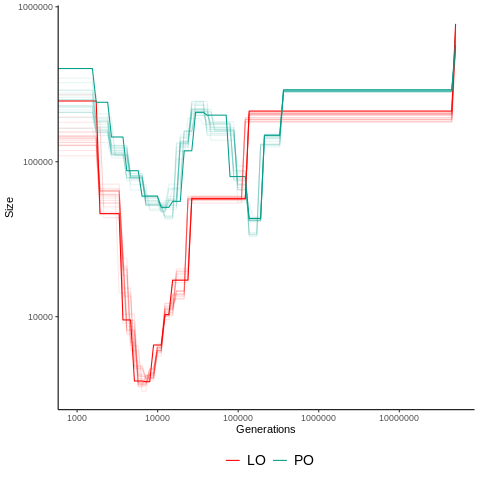

In [9]:
%%R
log_breaks = c(log(1000),log(10000),log(100000),log(1000000),log(10000000))
log_labels = c("1000","10000","100000","1000000","10000000")
dum = hists %>% group_by(pop,generations) %>% summarize(mean_size=mean(size),sd=sd(size),se = sd/sqrt(n()))
options(repr.plot.width=7,repr.plot.height=4)
ggplot() +
    geom_line(data = hists %>% filter(rep=="OG"), aes(x=log(generations),y=log(size),colour=pop)) + 
    geom_line(data = hists %>% filter(rep=="bootstrap"),aes(x=log(generations),y=log(size),color=pop,group=file),alpha=0.1) +
    scale_x_continuous(breaks=log_breaks,labels=log_labels) +
    scale_y_continuous(breaks=log_breaks,labels=log_labels) + 
    scale_color_manual(name="",values=wes_palette("Darjeeling1")) +
    scale_fill_manual(name="",values=wes_palette("Darjeeling1")) +
    ylab("Size") +
    xlab("Generations") +
    theme_classic() +
    theme(legend.position="bottom",legend.text=element_text(size=14))

## Split times

In [10]:
%%R
splits = list.files('./split/',pattern="csv",recursive=TRUE,full.names = TRUE)

read_split_hist = function(path){
    pair = basename(path) %>% gsub(".csv","",.) %>% str_split(.,"_") %>% map(extract,c(1)) %>% unlist(.) %>% paste(.,collapse="_")
    hist = read.csv(path)
    time = hist[nrow(hist),] %>% pull(x)
    df = data.frame(pair=as.character(pair),
                    time=as.numeric(time),
                    stringsAsFactors = FALSE)
    return(df)
    
}

split_dates = lapply(splits,function(path){read_split_hist(path)})
split_dates = bind_rows(split_dates)

mean(split_dates$time)
sd(split_dates$time)
sd(split_dates$time)/sqrt(nrow(split_dates))
split_dates %>% group_by(pair) %>% summarize(meanS = mean(time),maxS = max(time), minS = min(time), sdS = sd(time))

# A tibble: 1 × 5
  pair   meanS   maxS   minS   sdS
  <chr>  <dbl>  <dbl>  <dbl> <dbl>
1 POLO  21172. 23794. 17142. 2895.


In [13]:
%%R
library(MASS)
fitdistr(((split_dates$time)/3)/1e6, "normal")

       mean            sd     
  0.0070572890   0.0009416050 
 (0.0002054751) (0.0001452928)


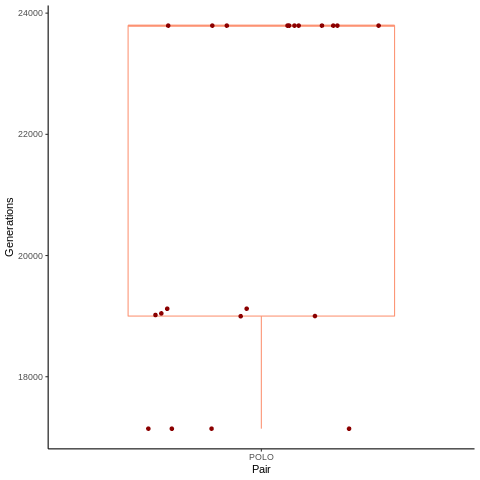

In [14]:
%%R
ggplot(split_dates,aes(x=pair,y=time)) +
    geom_boxplot(colour = "#fc9272") +
    geom_jitter(color="darkred") +
    theme_classic() +
    ylab("Generations") +
    xlab("Pair")